# 🚀 RankSEG Quickstart: Optimize Segmentation in 2 Minutes

This notebook demonstrates how to use **RankSEG** to improve segmentation masks from a pre-trained **DeepLabV3+** model without any retraining.

RankSEG replaces the standard `argmax` or thresholding step with a mathematically consistent solver (RMA) that directly optimizes for **Dice** or **IoU** metrics.

**Links:**
- [GitHub Repository](https://github.com/rankseg/rankseg)
- [Documentation](https://rankseg.readthedocs.io/)

## 1. Install RankSEG
Install the package directly from PyPI.

In [ ]:
!pip install rankseg

## 2. Setup & Load Pre-trained Model
We will use a standard ResNet-101 based DeepLabV3 model from `torchvision`.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import torch.nn.functional as F

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Pre-trained DeepLabV3
try:
    # New torchvision syntax
    weights = models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
    model = models.segmentation.deeplabv3_resnet101(weights=weights).to(device).eval()
except:
    # Fallback for older torchvision
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device).eval()

Using device: cpu
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:02<00:00, 92.9MB/s]


## 3. Prepare Input Image
We'll use a standard sample image for demonstration.

Image loaded successfully.


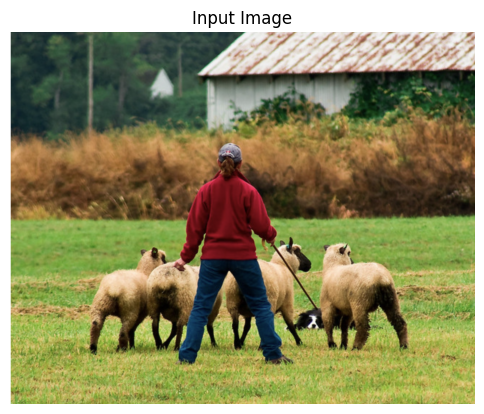

In [ ]:
import requests
from io import BytesIO

# Download sample image (Dog & Person)
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png"
response = requests.get(url)
input_image = Image.open(BytesIO(response.content)).convert("RGB")

# Preprocess for the model
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).unsqueeze(0).to(device)
print("Image loaded successfully.")

plt.figure(figsize=(6,6))
plt.imshow(input_image)
plt.axis('off')
plt.title("Input Image")
plt.show()

## 4. Run Inference (Get Probabilities)
First, we run the model to get the probability map. This is what RankSEG needs as input.

In [ ]:
with torch.no_grad():
    output = model(input_tensor)['out']
    # Softmax to get probabilities (Batch, Class, H, W)
    probs = F.softmax(output, dim=1)

print(f"Probability tensor shape: {probs.shape}")

Probability tensor shape: torch.Size([1, 21, 1026, 1282])


## 5. ⚡ Apply RankSEG
Here is the magic. Instead of just taking the `argmax`, we use RankSEG to find the prediction that maximizes the **Dice** score.

In [ ]:
from rankseg import RankSEG

# 1. Standard Argmax (Baseline)
argmax_pred = torch.argmax(probs, dim=1).cpu().numpy()[0]

# 2. RankSEG Optimization
# We target the 'dice' metric using the 'RMA' solver (Reciprocal Moment Approximation)
rankseg = RankSEG(metric='dice', solver='RMA')

rankseg_pred = rankseg.predict(probs).cpu().numpy()[0]

print("RankSEG optimization complete!")

RankSEG optimization complete!


## 6. Visual Comparison
Compare the standard Argmax result with the RankSEG optimized result. RankSEG typically produces smoother boundaries and recovers details that are statistically significant for the Dice metric.

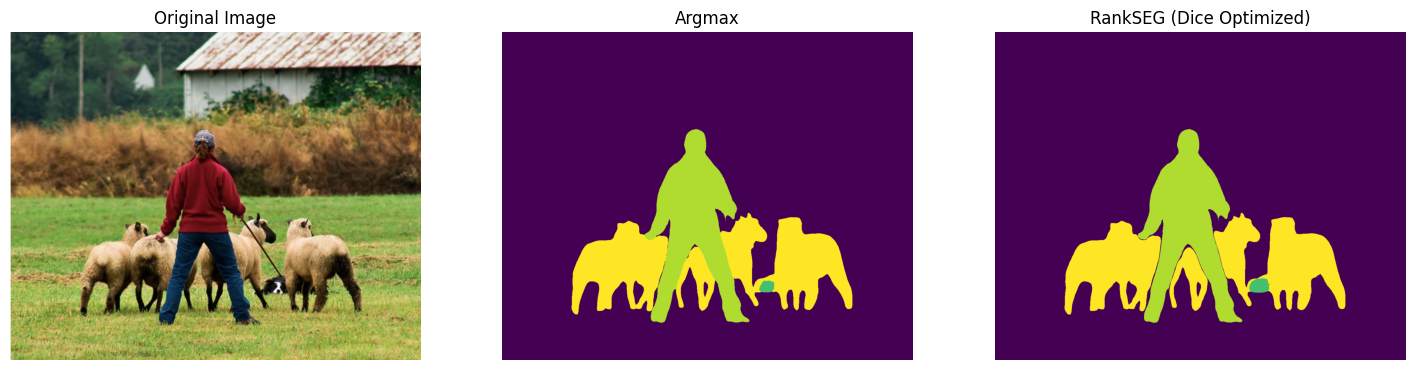

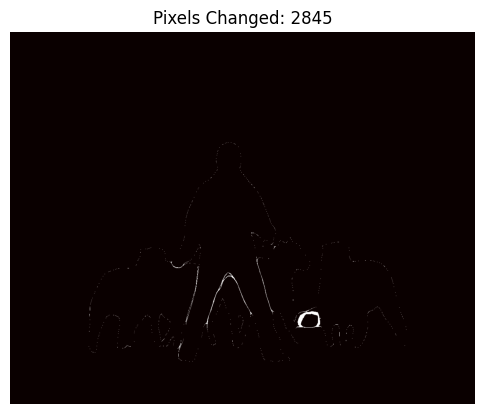

RankSEG modified 2845 pixels to improve the metric.


In [ ]:
def visualize_comparison(image, pred1, pred2, title1="Argmax", title2="RankSEG"):
    plt.figure(figsize=(18, 6))

    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Argmax
    plt.subplot(1, 3, 2)
    plt.imshow(pred1)
    plt.title(title1)
    plt.axis('off')

    # RankSEG
    plt.subplot(1, 3, 3)
    plt.imshow(pred2)
    plt.title(f"{title2} (Dice Optimized)")
    plt.axis('off')

    plt.show()

visualize_comparison(input_image, argmax_pred, rankseg_pred)

# Visualize Difference
diff = (argmax_pred != rankseg_pred)
num_changed = np.sum(diff)

if num_changed > 0:
    plt.figure(figsize=(6, 6))
    plt.imshow(diff, cmap='hot')
    plt.title(f"Pixels Changed: {num_changed}")
    plt.axis('off')
    plt.show()
    print(f"RankSEG modified {num_changed} pixels to improve the metric.")
else:
    print("RankSEG prediction is identical to Argmax (confidence was likely very high).")